# Use Off-Policy VPG with Baseline to Play CartPole-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
torch.manual_seed(0)

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

00:00:50 [INFO] env: <CartPoleEnv<CartPole-v0>>
00:00:50 [INFO] action_space: Discrete(2)
00:00:50 [INFO] observation_space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
00:00:50 [INFO] reward_range: (-inf, inf)
00:00:50 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
00:00:50 [INFO] _max_episode_steps: 200
00:00:50 [INFO] _elapsed_steps: None


In [3]:
class OffPolicyVPGwBaselineAgent:
    def __init__(self, env,):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.policy_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[],
                output_size=self.action_n, output_activator=nn.Softmax(1))
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=0.06)
        self.baseline_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[])
        self.baseline_optimizer = optim.Adam(self.policy_net.parameters(), lr=0.1)
        self.baseline_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None, use_bias=False):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size, bias=use_bias))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        if self.mode == 'train':
            action = np.random.choice(self.action_n) # use random policy
            self.trajectory += [observation, reward, done, action]
        else:
            state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
            prob_tensor = self.policy_net(state_tensor)
            action_tensor = distributions.Categorical(prob_tensor).sample()
            action = action_tensor.numpy()[0]
        return action

    def close(self):
        if self.mode == 'train':
            self.learn()

    def learn(self):
        state_tensor = torch.as_tensor(self.trajectory[0::4], dtype=torch.float)
        reward_tensor = torch.as_tensor(self.trajectory[1::4], dtype=torch.float)
        action_tensor = torch.as_tensor(self.trajectory[3::4], dtype=torch.long)
        arange_tensor = torch.arange(state_tensor.shape[0], dtype=torch.float)

        # train baseline
        discount_tensor = self.gamma ** arange_tensor
        discounted_reward_tensor = discount_tensor * reward_tensor
        discounted_return_tensor = discounted_reward_tensor.flip(0).cumsum(0).flip(0)
        return_tensor = discounted_return_tensor / discount_tensor
        pred_tensor = self.baseline_net(state_tensor)
        baseline_loss_tensor = self.baseline_loss(pred_tensor, return_tensor.unsqueeze(1))
        self.baseline_optimizer.zero_grad()
        baseline_loss_tensor.backward()
        self.baseline_optimizer.step()

        # train policy
        all_pi_tensor = self.policy_net(state_tensor)
        pi_tensor = torch.gather(all_pi_tensor, 1,
                action_tensor.unsqueeze(1)).squeeze(1)
        behavior_prob = 1. / self.action_n
        psi_tensor = discounted_return_tensor - pred_tensor.detach()
        policy_loss_tensor = -(psi_tensor / behavior_prob * pi_tensor).mean()
        self.policy_optimizer.zero_grad()
        policy_loss_tensor.backward()
        self.policy_optimizer.step()


agent = OffPolicyVPGwBaselineAgent(env)

00:00:50 [INFO] ==== train ====
00:00:50 [DEBUG] train episode 0: reward = 39.00, steps = 39
00:00:50 [DEBUG] train episode 1: reward = 56.00, steps = 56
00:00:50 [DEBUG] train episode 2: reward = 61.00, steps = 61
00:00:50 [DEBUG] train episode 3: reward = 72.00, steps = 72
00:00:50 [DEBUG] train episode 4: reward = 45.00, steps = 45
00:00:50 [DEBUG] train episode 5: reward = 39.00, steps = 39
00:00:50 [DEBUG] train episode 6: reward = 28.00, steps = 28
00:00:50 [DEBUG] train episode 7: reward = 129.00, steps = 129
00:00:50 [DEBUG] train episode 8: reward = 17.00, steps = 17
00:00:50 [DEBUG] train episode 9: reward = 24.00, steps = 24
00:00:50 [DEBUG] train episode 10: reward = 51.00, steps = 51
00:00:50 [DEBUG] train episode 11: reward = 16.00, steps = 16
00:00:50 [DEBUG] train episode 12: reward = 15.00, steps = 15
00:00:50 [DEBUG] train episode 13: reward = 32.00, steps = 32
00:00:50 [DEBUG] train episode 14: reward = 79.00, steps = 79
00:00:50 [DEBUG] train episode 15: reward = 44

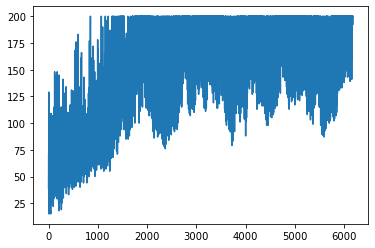

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-20:]) > 199:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()